# Multiple Linear Regression

In [5]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm
# If the observations are in a dataframe, you can use
# statsmodels.formulas.api to do the regression instead
from statsmodels import regression
import matplotlib.pyplot as plt
%matplotlib inline


Multiple linear regression generalizes linear regression, allowing the dependent variable to be a linear function of multiple independent variables. As before, we assume that the variable $Y$ is a linear function of $X_1,\ldots, X_k$:

$$ Y_i = \beta_0 + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$

Often in finance the form will be written as follows, but it is just the variable name that changes and otherwise the model is identical.

$$ Y_i = \alpha + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$

For observations $i = 1,2,\ldots, n$. In order to find the plane (or hyperplane) of best fit, we will use the method of ordinary least-squares (OLS), which seeks to minimize the squared error between predictions and observations, $\sum_{i=1}^n \epsilon_i^2$. The square makes makes psositive and negative errors equally bad, and magnifies large errors. It also makes the closed form math behind linear regression nice, but we won't go into that now. For an example of squared error, see the following.

Let's say Y is our actual data, and Y_hat is the predictions made by linear regression.

In [2]:
Y = np.array([1, 3.5, 4, 8, 12])
Y_hat = np.array([1, 3, 5, 7, 9])

print('Error {0}'.format(Y_hat-Y))

# Compute squared error

SE = (Y_hat - Y)**2

print('Squared Error {0}'.format(SE))
print('Sum Squared Error {0}'.format(np.sum(SE)))

Error [ 0.  -0.5  1.  -1.  -3. ]
Squared Error [ 0.    0.25  1.    1.    9.  ]
Sum Squared Error 11.25


Once we have used this method to determine the coefficients of the regression, we will be able to use new observed values of $X$ to predict values of $Y$. 

Each coefficient $\beta_j$ tells us how much $Y_i$ will change if we change $X_j$ by one while holding all of the other dependent variables constant. This lets us separate out the contributions of different effects. This is assuming the linear model is the correct one.

We start by artificially constructing a $Y$, $X_1$, and $X_2$ in which we know the precise relationship.

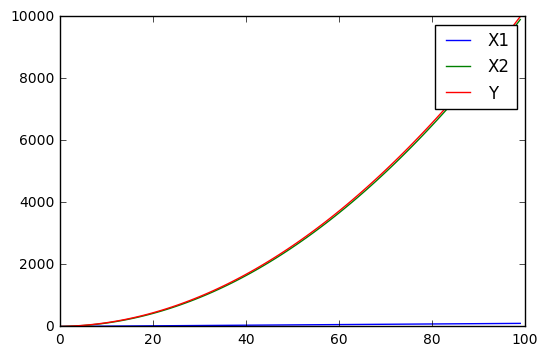

In [6]:
# Construct a simple linear curve of 1, 2, 3,...
X1 = np.arange(100)

# Make a parabola and add X1 to it, this is X2
X2 = np.array([i**2 for i in range(100)]) + X1

# This is our real Y constructed using a linear
# combination of X1 and X2
Y = X1 + X2

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(Y, label='Y')
plt.legend();

We can use the same model from `statsmodels` as we did for a single linear regression lecture.

In [10]:
# Use column_stack to combine independent variables,
# then add a column of ones so we can fit an intercept
X = sm.add_constant(np.column_stack((X1,X2)))

# Run the model
results = regression.linear_model.OLS(Y, X).fit()

print('Beta_0: {0}'.format(results.params[0]))
print('Beta_1: {0}'.format(results.params[1]))
print('Beta_2: {0}'.format(results.params[2]))

Beta_0: 1.9895196601282805e-13
Beta_1: 1.0000000000004512
Beta_2: 0.9999999999999942


The same care must be taken with these results as with partial derivatives. The formula for $Y$ is ostensibly 

$$X_1 + X_2 = X_1 + X^2 + X_1 = 2 X_1 + X^2$$

Or $2X_1$ plus a parabola.

However, the coefficient of $X_1$ is 1. That is because $Y$ changes by 1 if we change $X_1$ by 1 <i>while holding $X_2$ constant</i>. Multiple linear regression separates out contributions from different variables.

Similarly, running a linear regression on two securities might give a high $\beta$. However, if we bring in a third security (like SPY, which tracks the S&P 500) as an independent variable, we may find that the correlation between the first two securities is almost entirely due to them both being correlated with the S&P 500. This is useful because the S&P 500 may then be a more reliable predictor of both securities than they were of each other. This method allows us to better gauge the significance between the two securities and the problem is known as confounding.

In [12]:
import pandas_datareader.data as web
import datetime

In [39]:
# Load pricing data for two arbitrarily-chosen assets and SPY
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2015,1,1)

asset1 = web.DataReader('EXR', 'yahoo', start, end).Close
asset2 = web.DataReader('FB', 'yahoo', start, end).Close
benchmark = web.DataReader('SPY', 'yahoo', start, end).Close

# First, run a linear regression of the two assets
slr = regression.linear_model.OLS(asset1, sm.add_constant(asset2)).fit()
print('SLR beta of asset2: {0}'.format(slr.params[1]))

SLR beta of asset2: 0.40788919460947476


In [40]:
slr.params

const    24.019886
Close     0.407889
dtype: float64

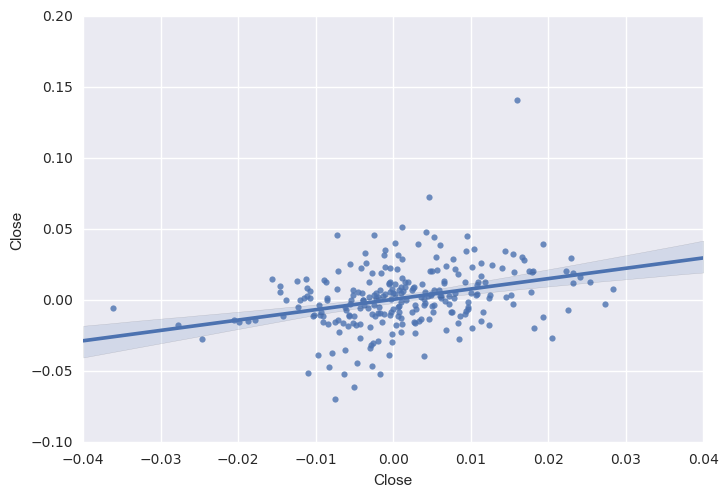

In [43]:
import seaborn as sns
sns.regplot(asset1.pct_change()[1:], asset2.pct_change()[1:]);

In [42]:
# Run multiple linear regression using asset2 and SPY as independent variable
mlr = regression.linear_model.OLS(asset1, sm.add_constant(np.column_stack((asset2, benchmark)))).fit()

prediction = mlr.params[0] + mlr.params[1]*asset2 + mlr.params[2]* benchmark
prediction.name = 'Prediction'

print('MLR beta of asset2: {0}'.format(mlr.params[1]))
print('MLR beta of S&P 500: {0}'.format(mlr.params[2]))

MLR beta of asset2: 0.051683028255963076
MLR beta of S&P 500: 0.44052391598923574


The next step after running an analysis is determining if we can even trust the results. A good first step is checking to see if anything looks weird in graphs of the independent variables, dependent variables, and predictions.

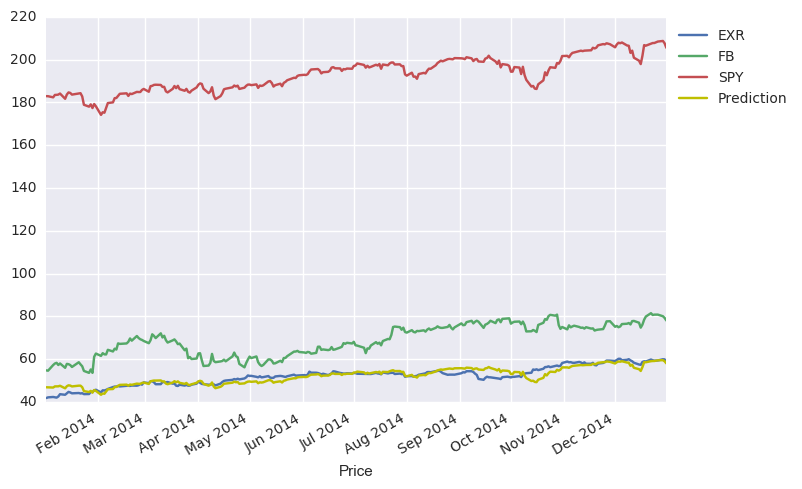

In [45]:
# Plot the three variables along with the prediction given by the MLR
asset1.name = 'EXR'
asset2.name = 'FB'
benchmark.name = 'SPY'
asset1.plot()
asset2.plot()
benchmark.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend(bbox_to_anchor=(1,1), loc=2);

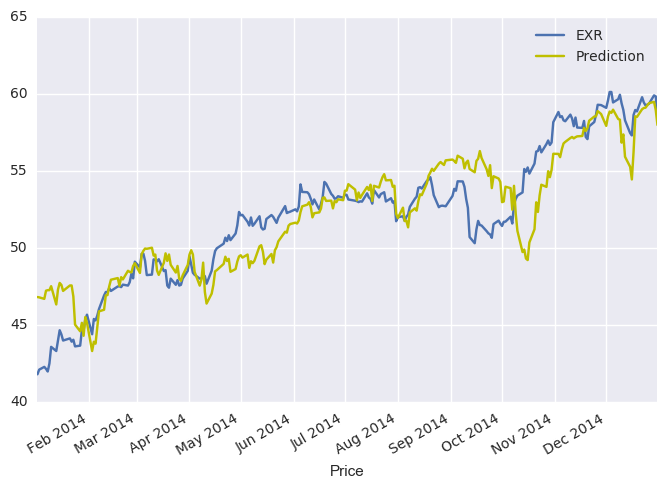

In [46]:
# Plot only the dependent variable and the prediction to get a closer look
asset1.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend();

## Evaluation
We can get some statistics about the fit from the result returned by the regression.

In [47]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EXR   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     444.7
Date:                Wed, 21 Dec 2016   Prob (F-statistic):           6.64e-83
Time:                        14:15:12   Log-Likelihood:                -535.93
No. Observations:                 252   AIC:                             1078.
Df Residuals:                     249   BIC:                             1088.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -36.6038      3.564    -10.269      0.000       -43.624   -29.584
x1             0.0517      0.026      1.975      0.049         0.000     0.103
x2             0.4405      0.024     18.040      0.000         0.392     0.489
==============================================================================
Omnibus:                        6.341   Durbin-Watson:                   0.087
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.159
Skew:                          -0.323   Prob(JB):                       0.0460
Kurtosis:                       3.412   Cond. No.                     5.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model Assumptions

The validity of these statistics depends on whether or not the assumptions of the linear regression model are satisfied. These are:
* The independent variable is not random.
* The variance of the error term is constant across observations. This is important for evaluating the goodness of the fit.
* The errors are not autocorrelated. The Durbin-Watson statistic reported by the regression detects this. If it is close to $2$, there is no autocorrelation.
* The errors are normally distributed. If this does not hold, we cannot use some of the statistics, such as the F-test.

Multiple linear regression also requires an additional assumption:
* There is no exact linear relationship between the independent variables. Otherwise, it is impossible to solve for the coefficients $\beta_i$ uniquely, since the same linear equation can be expressed in multiple ways.

If there is a linear relationship between any set of independent variables, also known as covariance, we say that they are linear combinations of each other. In the case where they are dependent on each other in this manner, the values of our $\beta_i$ coefficients will be inaccurate for a given $X_i$. The intuition for this can be found in an exteme example where $X_1$ and $X_2$ are 100% covarying. In that case then linear regression can equivalently assign the total coefficient sum in any combination without affecting the predictive capability.

$$ 1X_1 + 0X_2 = 0.5X_1 + 0.5X_2 = 0X_1 + 1X_2 $$


While our coefficients may be nondescriptive, the ultimate model may still be accurate provided that there is a good overall fit between the independent variables and the dependent variables. The best practice for constructing a model where dependence is a problem is to leave out the less descriptive variables that are correlated with the better ones. This improves the model by reducing the chances of overfitting while bringing the $\beta_i$ estimates closer to their true values.

If we confirm that the necessary assumptions of the regression model are satisfied, we can safely use the statistics reported to analyze the fit. For example, the $R^2$ value tells us the fraction of the total variation of $Y$ that is explained by the model. When doing multiple linear regression, however, we prefer to use adjusted $R^2$, which corrects for the small increases in $R^2$ that occur when we add more regression variables to the model, even if they are not significantly correlated with the dependent variable. Adjusted $R^2$ is defined as

$$ 1 - (1 - R^2)\frac{n-1}{n-k-1} $$

Where $n$ is the number of observations and $k$ is the number of independent variables in the model. Other useful statistics include the F-statistic and the standard error of estimate.

# Model Selection Example

When deciding on the best possible model of your dependent variables, there are several different methods to turn to. If you use too many explanatory variables, you run the risk of overfitting your model, but if you use too few you may end up with a terrible fit. One of the most prominent methods to decide on a best model is stepwise regression. Forward stepwise regression starts from an empty model and tests each individual variable, selecting the one that results in the best model quality, usually measured with AIC or BIC (lowest is best). It then adds the remaining variables one at a time, testing each subsequent combination of explanatory variables in a regression and calculating the AIC or BIC value at each step. At the end of the regression, the model with the best quality (according to the given measure) is selected and presented as a the final, best model. This does have limitations, however. It does not test every single possible combination of variables so it may miss the theoretical best model if a particular variable was written off earlier in performing the algorithm. As such, stepwise regression should be used in combination with your best judgment regarding the model.

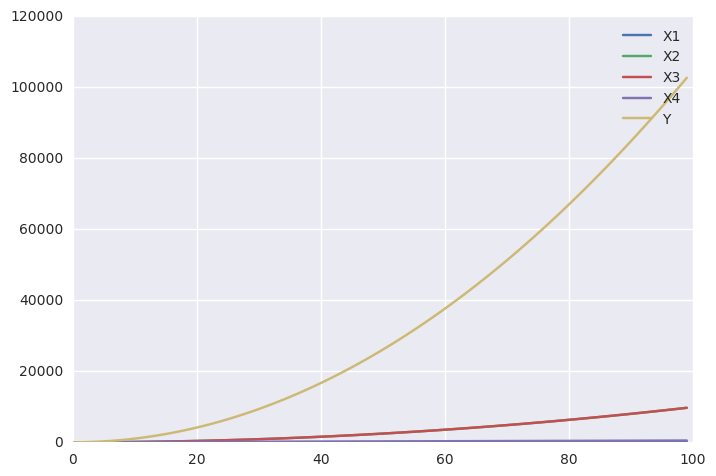

In [48]:
X1 = np.arange(100)
X2 = [i**2 for i in range(100)] - X1
X3 = [np.log(i) for i in range(1,101)] + X2
X4 = 5*X1
Y = 2*X1 + 0.5*X2 + 10*X3 + X4

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(X3, label='X3')
plt.plot(X4, label='X4')
plt.plot(Y, label='Y')
plt.legend();

In [49]:
results = regression.linear_model.OLS(Y, sm.add_constant(np.column_stack((X1,X2,X3,X4)))).fit()

print("Beta_0: ", results.params[0])
print("Beta_1: ", results.params[1])
print("Beta_2: ", results.params[2])
print("Beta_3: ", results.params[3])
print("Beta_4: ", results.params[4])

Beta_0:  -5.50244294573e-11
Beta_1:  0.269230769231
Beta_2:  0.499999999967
Beta_3:  10.0
Beta_4:  1.34615384615


In [50]:
data = pd.DataFrame(np.column_stack((X1,X2,X3,X4)), columns = ['X1','X2','X3','X4'])
response = pd.Series(Y, name='Y')

In [51]:
data.shape


(100, 4)

In [58]:
def forward_reg(response, data, method='aic'):
    # This function will work with pandas dataframes and series
    
    # Initialize some variables
    explanatory = list(data.columns)
    # selected - initialize as a series of 1s (the constant for the intercept)
    selected = pd.Series(np.ones(data.shape[0]), name='Intercept')
    # initialize scores as infinity (as high as possible)
    current_score, best_new_score = np.inf, np.inf
    
    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:
        
        scores_with_elements = []
        count = 0
        
        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our
            # current best and the new one
            temp = pd.concat([selected, data[element]], axis=1)
            #Test the new set
            result = regression.linear_model.OLS(Y, temp).fit()
            if method=='bic':
                score = result.bic
            elif method=='combo':
                score = result.aic + result.bic
            else:
                score = result.aic
            scores_with_elements.append((score, element, count))
            count +=1
            
        # Sort the scoring list
        scores_with_elements.sort(reverse=True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score: # remember lower is better
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, data[best_element]],axis=1)
            current_score = best_new_score
    # Return the final model
    model = regression.linear_model.OLS(Y, selected).fit()
    return model

In [59]:
result = forward_reg(Y, data, method='aic')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.884e+26
Date:                Wed, 21 Dec 2016   Prob (F-statistic):               0.00
Time:                        18:16:16   Log-Likelihood:                 1723.6
No. Observations:                 100   AIC:                            -3439.
Df Residuals:                      96   BIC:                            -3429.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    6.73e-11   5.58e-09      0.012      0.990      -1.1e-08  1.11e-08
X3            10.0000   3.37e-09   2.96e+09      0.000        10.000    10.000
X1             0.2692   1.03e-11   2.61e+10      0.000         0.269     0.269
X2             0.5000   3.37e-09   1.48e+08      0.000         0.500     0.500
X4             1.3462   5.16e-11   2.61e+10      0.000         1.346     1.346
==============================================================================
Omnibus:                       14.071   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.973
Skew:                           0.647   Prob(JB):                      0.00683
Kurtosis:                       2.152   Cond. No.                     1.38e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  2e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In the construction of this model, the $X_4$ term is highly closely related to the $X_1$ term, simply multiplying it by a scalar. However, stepwise regression did not catch this and remove the variable and simply adjust the coefficient of the $X_1$ term. Our own judgment would say to leave the $X_4$ term out of the model, showing the limitations of stepwise regression.

There are other ways to diagnose the health of a model and individual variables with varying degrees of penalty given to more complex models. This will be covered in-depth in a model selection notebook.

### Testing the other methods quickly
Do the other methods eliminate the $X_4$ variable?

In [60]:
# Forwrard bic
result = forward_reg(Y, data, method='bic')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.884e+26
Date:                Wed, 21 Dec 2016   Prob (F-statistic):               0.00
Time:                        18:20:07   Log-Likelihood:                 1723.6
No. Observations:                 100   AIC:                            -3439.
Df Residuals:                      96   BIC:                            -3429.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    6.73e-11   5.58e-09      0.012      0.990      -1.1e-08  1.11e-08
X3            10.0000   3.37e-09   2.96e+09      0.000        10.000    10.000
X1             0.2692   1.03e-11   2.61e+10      0.000         0.269     0.269
X2             0.5000   3.37e-09   1.48e+08      0.000         0.500     0.500
X4             1.3462   5.16e-11   2.61e+10      0.000         1.346     1.346
==============================================================================
Omnibus:                       14.071   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.973
Skew:                           0.647   Prob(JB):                      0.00683
Kurtosis:                       2.152   Cond. No.                     1.38e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  2e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [61]:
# Forward aic bic combination
result = forward_reg(Y, data, method='combo')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.884e+26
Date:                Wed, 21 Dec 2016   Prob (F-statistic):               0.00
Time:                        18:20:33   Log-Likelihood:                 1723.6
No. Observations:                 100   AIC:                            -3439.
Df Residuals:                      96   BIC:                            -3429.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    6.73e-11   5.58e-09      0.012      0.990      -1.1e-08  1.11e-08
X3            10.0000   3.37e-09   2.96e+09      0.000        10.000    10.000
X1             0.2692   1.03e-11   2.61e+10      0.000         0.269     0.269
X2             0.5000   3.37e-09   1.48e+08      0.000         0.500     0.500
X4             1.3462   5.16e-11   2.61e+10      0.000         1.346     1.346
==============================================================================
Omnibus:                       14.071   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.973
Skew:                           0.647   Prob(JB):                      0.00683
Kurtosis:                       2.152   Cond. No.                     1.38e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  2e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In this case, neither forward test recognized the linear dependence of variables $X_1$ and $X_4$